In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Set style for consistent plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("=" * 80)
print("HOMEWORK: HOUSING MARKET ANALYSIS")
print("Nonparametric Methods: Splines and Decision Trees")
print("=" * 80)

# =============================================================================
# DATA GENERATION (DO NOT MODIFY THIS SECTION)
# =============================================================================

np.random.seed(2024)  # For reproducibility
n = 8000

# Generate housing market data
square_feet = np.random.uniform(800, 4000, n)
lot_size = np.random.uniform(2000, 15000, n) 
age = np.random.uniform(0, 80, n)
bedrooms = np.random.choice([1, 2, 3, 4, 5, 6], n, p=[0.05, 0.15, 0.35, 0.30, 0.10, 0.05])
bathrooms = np.random.choice([1, 1.5, 2, 2.5, 3, 3.5, 4], n, 
                              p=[0.10, 0.10, 0.30, 0.20, 0.15, 0.10, 0.05])
garage_spaces = np.random.choice([0, 1, 2, 3], n, p=[0.10, 0.30, 0.50, 0.10])

# Location features
distance_to_city = np.random.uniform(0.5, 30, n)  # miles
school_rating = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], n,
                                  p=[0.02, 0.03, 0.05, 0.10, 0.15, 0.20, 0.20, 0.15, 0.07, 0.03])
crime_rate = np.random.uniform(1, 100, n)  # per 1000 residents

# Economic variables
unemployment_rate = np.random.uniform(2, 12, n)  # percent
median_income = np.random.uniform(30000, 150000, n)  # dollars

# Generate true house prices with nonlinear relationships
def true_price_function(sqft, age, dist, school, crime, income):
    """
    True data generating process
    - Square footage: linear with diminishing returns at high values
    - Age: depreciation with floor effect
    - Distance: negative effect that diminishes
    - School rating: nonlinear positive effect
    - Crime: negative effect
    - Income: captures neighborhood quality
    """
    base_price = 50000
    
    # Square feet: log relationship (diminishing returns)
    sqft_effect = 80 * np.log(sqft)
    
    # Age: depreciation but levels off for very old homes (vintage effect)
    age_effect = -2000 * np.log(age + 1) + 100 * (age > 50)
    
    # Distance to city: negative effect that diminishes
    dist_effect = -5000 * np.log(dist + 1)
    
    # School rating: nonlinear (quadratic)
    school_effect = 2000 * school + 200 * school**2
    
    # Crime: negative effect
    crime_effect = -200 * crime
    
    # Median income: proxy for neighborhood quality
    income_effect = 1.5 * income
    
    price = (base_price + sqft_effect + age_effect + dist_effect + 
             school_effect + crime_effect + income_effect)
    
    return np.maximum(price, 20000)  # Floor price

price = true_price_function(square_feet, age, distance_to_city, 
                            school_rating, crime_rate, median_income)

# Add noise
price = price * np.random.lognormal(0, 0.15, n)

# Create DataFrame
data = pd.DataFrame({
    'price': price,
    'square_feet': square_feet,
    'lot_size': lot_size,
    'age': age,
    'bedrooms': bedrooms,
    'bathrooms': bathrooms,
    'garage_spaces': garage_spaces,
    'distance_to_city': distance_to_city,
    'school_rating': school_rating,
    'crime_rate': crime_rate,
    'unemployment_rate': unemployment_rate,
    'median_income': median_income
})

# INTRODUCE MISSING VALUES (realistic patterns)
# Missing data is NOT random - this is important!

# Older homes more likely to have missing lot_size (records lost)
missing_lot_mask = (data['age'] > 50) & (np.random.random(n) < 0.15)
data.loc[missing_lot_mask, 'lot_size'] = np.nan

# Crime rate missing for some low-crime areas (not reported)
missing_crime_mask = (data['crime_rate'] < 20) & (np.random.random(n) < 0.10)
data.loc[missing_crime_mask, 'crime_rate'] = np.nan

# School rating missing for some areas
missing_school_mask = np.random.random(n) < 0.08
data.loc[missing_school_mask, 'school_rating'] = np.nan

# Random missing in median_income
missing_income_mask = np.random.random(n) < 0.12
data.loc[missing_income_mask, 'median_income'] = np.nan

print("\n✓ Dataset generated successfully!")
print(f"  Total observations: {len(data)}")
print(f"  Features: {len(data.columns) - 1}")
print(f"  Target: house price")


HOMEWORK: HOUSING MARKET ANALYSIS
Nonparametric Methods: Splines and Decision Trees

✓ Dataset generated successfully!
  Total observations: 8000
  Features: 11
  Target: house price


In [38]:
# =============================================================================
# QUESTION 1: EXPLORATORY DATA ANALYSIS (15 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 1: EXPLORATORY DATA ANALYSIS (15 points)")
print("=" * 80)

# Q1.1 (3 points): Display basic information about the dataset
print("\nQ1.1: Display the first 10 rows and basic dataset info")
print("-" * 60)

print(data.head(10))
print("\nDataset Info:")
print(data.info())
print("\nMissing Values per Column:")
print(data.isnull().sum())


QUESTION 1: EXPLORATORY DATA ANALYSIS (15 points)

Q1.1: Display the first 10 rows and basic dataset info
------------------------------------------------------------
           price  square_feet      lot_size        age  bedrooms  bathrooms  \
0  104237.044407  2681.646460  13596.884522  77.807425         3        1.5   
1  282734.415368  3037.147993   9763.679213  69.103398         5        2.0   
2  108985.909983  1402.086272  14432.548703   8.744498         3        2.0   
3  281495.055657   940.187404   6908.538751  70.396849         4        1.5   
4  139134.888396  1456.060648   8855.097806  66.376556         3        1.0   
5  136767.057466  1139.401198   8161.873814  20.577229         3        2.0   
6  262486.379794  3127.168460   6498.646619  66.282576         2        2.0   
7  172327.529984  2974.081675  11474.985897   8.352807         3        2.0   
8  234176.925099  2316.306251  10198.496020  78.899452         4        2.0   
9  116717.252408  2234.546638   5309.16249

In [39]:
# Q1.2 (4 points): Identify and report missing values
print("\nQ1.2: Identify missing values")
print("-" * 60)
print("Report the number and percentage of missing values for each column.")

missing_summary = pd.DataFrame({
    'Missing Count': data.isnull().sum(),
    'Missing Percentage': data.isnull().mean() * 100
})
print(missing_summary)



Q1.2: Identify missing values
------------------------------------------------------------
Report the number and percentage of missing values for each column.
                   Missing Count  Missing Percentage
price                          0              0.0000
square_feet                    0              0.0000
lot_size                     459              5.7375
age                            0              0.0000
bedrooms                       0              0.0000
bathrooms                      0              0.0000
garage_spaces                  0              0.0000
distance_to_city               0              0.0000
school_rating                693              8.6625
crime_rate                   146              1.8250
unemployment_rate              0              0.0000
median_income                994             12.4250


In [40]:
# Q1.3 (4 points): Create summary statistics
print("\nQ1.3: Create a summary statistics table")
print("-" * 60)
print("For the target variable (price), report:")
print("  - Mean, Median, Std Dev, Min, Max")
print("  - Skewness (hint: from scipy.stats import skew)")

price_stats = {
    'Mean': data['price'].mean(),
    'Median': data['price'].median(),
    'Std Dev': data['price'].std(),
    'Min': data['price'].min(),
    'Max': data['price'].max(),
    'Skewness': data['price'].skew()
}
price_stats_df = pd.DataFrame(price_stats, index=[0])
price_stats_df


Q1.3: Create a summary statistics table
------------------------------------------------------------
For the target variable (price), report:
  - Mean, Median, Std Dev, Min, Max
  - Skewness (hint: from scipy.stats import skew)


,Mean,Median,Std Dev,Min,Max,Skewness
0,178035.579318,174349.757133,60019.986647,47176.707008,432228.431193,0.362572



Q1.4: Create visualizations for key variables
------------------------------------------------------------
Create a 2x3 subplot showing:
  - Histogram of price
  - Histogram of log(price)
  - Scatter: price vs square_feet
  - Scatter: price vs age
  - Scatter: price vs distance_to_city
  - Box plot: price by school_rating


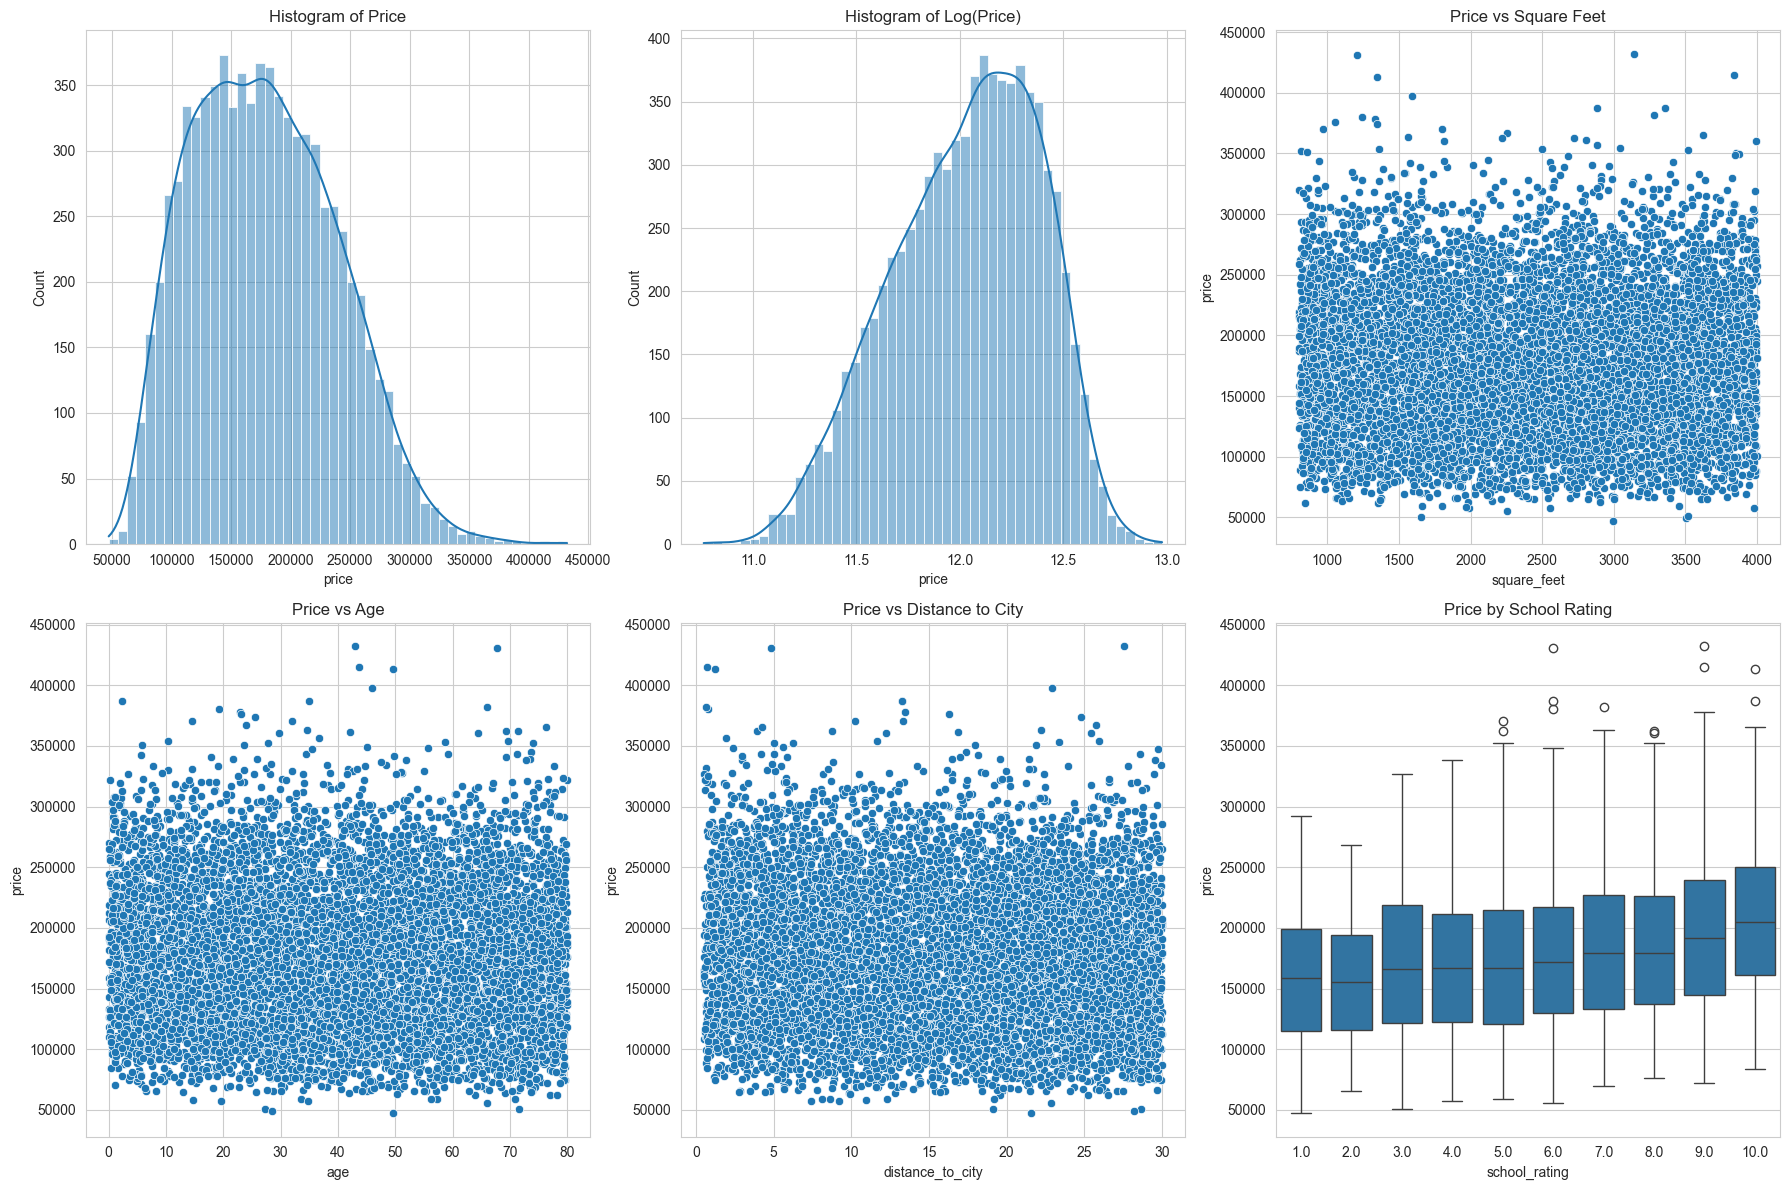

'\nBased on your visualizations, answer the following:\na) Is the price distribution skewed? Should we use log(price)?\nb) Which variables appear to have nonlinear relationships with price?\nc) Are there any obvious outliers?\n\nYOUR ANSWER:\na) Yes, the price distribution is right-skewed, indicating that a few high-priced homes are pulling the mean up. Using log(price) helps to normalize the distribution and reduce skewness, making it more suitable for modeling.\nb) Variables such as square_feet, age, and distance_to_city show nonlinear relationships with price. For instance, the relationship between price and square_feet appears to have diminishing returns at higher values, while age shows a depreciation effect that levels off for older homes.\nc) Yes, there are some obvious outliers, particularly in the price variable where a few homes are priced significantly higher than the rest. These outliers could potentially influence model performance and should be investigated further.\n'

In [41]:
# Q1.4 (4 points): Visualize distributions
print("\nQ1.4: Create visualizations for key variables")
print("-" * 60)
print("Create a 2x3 subplot showing:")
print("  - Histogram of price")
print("  - Histogram of log(price)")
print("  - Scatter: price vs square_feet")
print("  - Scatter: price vs age") 
print("  - Scatter: price vs distance_to_city")
print("  - Box plot: price by school_rating")

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
# Histogram of price
sns.histplot(data['price'], bins=50, ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Histogram of Price')
# Histogram of log(price)
sns.histplot(np.log(data['price']), bins=50, ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Histogram of Log(Price)')
# Scatter: price vs square_feet
sns.scatterplot(x='square_feet', y='price', data=data, ax=axs[0, 2])
axs[0, 2].set_title('Price vs Square Feet')
# Scatter: price vs age
sns.scatterplot(x='age', y='price', data=data, ax=axs[1, 0])
axs[1, 0].set_title('Price vs Age')
# Scatter: price vs distance_to_city
sns.scatterplot(x='distance_to_city', y='price', data=data, ax=axs[1, 1])
axs[1, 1].set_title('Price vs Distance to City')
# Box plot: price by school_rating
sns.boxplot(x='school_rating', y='price', data=data, ax=axs[1, 2])
axs[1, 2].set_title('Price by School Rating')
plt.tight_layout()
plt.show()

# WRITTEN ANSWER Q1.4:
"""
Based on your visualizations, answer the following:
a) Is the price distribution skewed? Should we use log(price)?
b) Which variables appear to have nonlinear relationships with price?
c) Are there any obvious outliers?

YOUR ANSWER:
a) Yes, the price distribution is right-skewed, indicating that a few high-priced homes are pulling the mean up. Using log(price) helps to normalize the distribution and reduce skewness, making it more suitable for modeling.
b) Variables such as square_feet, age, and distance_to_city show nonlinear relationships with price. For instance, the relationship between price and square_feet appears to have diminishing returns at higher values, while age shows a depreciation effect that levels off for older homes.
c) Yes, there are some obvious outliers, particularly in the price variable where a few homes are priced significantly higher than the rest. These outliers could potentially influence model performance and should be investigated further.
"""


In [42]:
# =============================================================================
# QUESTION 2: DATA CLEANING AND FEATURE ENGINEERING (20 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 2: DATA CLEANING AND FEATURE ENGINEERING (20 points)")
print("=" * 80)

# Q2.1 (8 points): Handle missing values
print("\nQ2.1: Handle missing values")
print("-" * 60)
print("Impute missing values using appropriate strategies:")
print("  - lot_size: use median")
print("  - crime_rate: use median")
print("  - school_rating: use mode (most common value)")
print("  - median_income: use mean")
print("\nCreate a new DataFrame called 'data_clean' with imputed values.")

### YOUR CODE HERE ###
# Make a copy of the data
data_clean = data.copy()

# Impute missing values

data_clean['lot_size'].fillna(data_clean['lot_size'].median(), inplace=True)
data_clean['crime_rate'].fillna(data_clean['crime_rate'].median(), inplace=True)
data_clean['school_rating'].fillna(data_clean['school_rating'].mode()[0], inplace=True)
data_clean['median_income'].fillna(data_clean['median_income'].mean(), inplace=True)

# Verify no missing values remain
print("\nMissing values after imputation:")
print(data_clean.isnull().sum())



QUESTION 2: DATA CLEANING AND FEATURE ENGINEERING (20 points)

Q2.1: Handle missing values
------------------------------------------------------------
Impute missing values using appropriate strategies:
  - lot_size: use median
  - crime_rate: use median
  - school_rating: use mode (most common value)
  - median_income: use mean

Create a new DataFrame called 'data_clean' with imputed values.

Missing values after imputation:
price                0
square_feet          0
lot_size             0
age                  0
bedrooms             0
bathrooms            0
garage_spaces        0
distance_to_city     0
school_rating        0
crime_rate           0
unemployment_rate    0
median_income        0
dtype: int64


In [43]:
# Q2.2 (6 points): Create new features
print("\nQ2.2: Feature engineering")
print("-" * 60)
print("Create the following new features:")
print("  1. 'price_per_sqft': price divided by square_feet")
print("  2. 'total_rooms': bedrooms + bathrooms")
print("  3. 'age_category': 'new' (age<10), 'mid' (10-30), 'old' (>30)")
print("  4. 'luxury': 1 if (bedrooms>=4 AND bathrooms>=3), else 0")

data_clean['price_per_sqft'] = data_clean['price'] / data_clean['square_feet']
data_clean['total_rooms'] = data_clean['bedrooms'] + data_clean['bathrooms']
data_clean['age_category'] = pd.cut(data_clean['age'], bins=[-1, 10, 30, np.inf], labels=['new', 'mid', 'old'])
data_clean['luxury'] = np.where((data_clean['bedrooms'] >= 4) & (data_clean['bathrooms'] >= 3), 1, 0)

data_clean.head()


Q2.2: Feature engineering
------------------------------------------------------------
Create the following new features:
  1. 'price_per_sqft': price divided by square_feet
  2. 'total_rooms': bedrooms + bathrooms
  3. 'age_category': 'new' (age<10), 'mid' (10-30), 'old' (>30)
  4. 'luxury': 1 if (bedrooms>=4 AND bathrooms>=3), else 0


,price,square_feet,lot_size,age,bedrooms,bathrooms,garage_spaces,distance_to_city,school_rating,crime_rate,unemployment_rate,median_income,price_per_sqft,total_rooms,age_category,luxury
0,104237.044407,2681.646460,13596.884522,77.807425,3,1.5,2,11.663771,9.0,11.958240,5.069577,46475.041552,38.870539,4.5,old,0
1,282734.415368,3037.147993,9763.679213,69.103398,5,2.0,1,21.773962,5.0,15.682850,7.280196,141177.614526,93.092077,7.0,old,0
2,108985.909983,1402.086272,14432.548703,8.744498,3,2.0,2,19.393877,7.0,51.942017,5.693237,37765.885423,77.731244,5.0,new,0
3,281495.055657,940.187404,6908.538751,70.396849,4,1.5,0,9.186639,6.0,64.596741,4.438200,121921.192046,299.403134,5.5,old,0
4,139134.888396,1456.060648,8855.097806,66.376556,3,1.0,1,15.703066,8.0,58.972815,2.003146,60560.715765,95.555696,4.0,old,0


In [44]:
# Q2.3 (6 points): Create dummy variables
print("\nQ2.3: Create dummy variables for school_rating")
print("-" * 60)
print("Create dummy variables for school_rating (treat as categorical)")
print("Use pd.get_dummies() and add to data_clean")

school_dummies = pd.get_dummies(data_clean['school_rating'], prefix='school', drop_first=True)
data_clean = pd.concat([data_clean, school_dummies], axis=1)

print("\n✓ Data cleaning and feature engineering complete!")
print(f"  Final dataset shape: {data_clean.shape}")



Q2.3: Create dummy variables for school_rating
------------------------------------------------------------
Create dummy variables for school_rating (treat as categorical)
Use pd.get_dummies() and add to data_clean

✓ Data cleaning and feature engineering complete!
  Final dataset shape: (8000, 25)


In [45]:
# =============================================================================
# QUESTION 3: TRAIN/TEST SPLIT AND SCALING (10 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 3: TRAIN/TEST SPLIT AND SCALING (10 points)")
print("=" * 80)

# Q3.1 (5 points): Create train/test split
print("\nQ3.1: Split data into training (70%) and test (30%) sets")
print("-" * 60)
print("Use the following features (continuous only for now):")
features_to_use = ['square_feet', 'lot_size', 'age', 'bedrooms', 
                   'bathrooms', 'garage_spaces', 'distance_to_city',
                   'crime_rate', 'unemployment_rate', 'median_income']


# Create X (features) and y (target: price)
# Split into train and test sets (test_size=0.3, random_state=42)
X = data_clean[features_to_use]
y = data_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



QUESTION 3: TRAIN/TEST SPLIT AND SCALING (10 points)

Q3.1: Split data into training (70%) and test (30%) sets
------------------------------------------------------------
Use the following features (continuous only for now):

Training set size: (5600, 10)
Test set size: (2400, 10)


In [46]:
# Q3.2 (5 points): Scale the features
print("\nQ3.2: Standardize the features (mean=0, std=1)")
print("-" * 60)
print("Use StandardScaler. Important: fit on training data only!")

# Create scaler, fit on training data, transform both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data split and scaled!")


Q3.2: Standardize the features (mean=0, std=1)
------------------------------------------------------------
Use StandardScaler. Important: fit on training data only!

✓ Data split and scaled!


In [47]:
# =============================================================================
# QUESTION 4: LINEAR REGRESSION BASELINE (10 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 4: LINEAR REGRESSION BASELINE (10 points)")
print("=" * 80)

# Q4.1 (5 points): Fit linear regression
print("\nQ4.1: Fit a linear regression model")
print("-" * 60)

# Fit model, make predictions, calculate MSE and R² for both train and test
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_train_pred_linear = lin_reg.predict(X_train_scaled)
y_test_pred_linear = lin_reg.predict(X_test_scaled)
train_mse_linear = mean_squared_error(y_train, y_train_pred_linear)
test_mse_linear = mean_squared_error(y_test, y_test_pred_linear)
train_r2_linear = r2_score(y_train, y_train_pred_linear)
test_r2_linear = r2_score(y_test, y_test_pred_linear)
    
print("\nLinear Regression Results:")
print(f"  Training MSE: {train_mse_linear:.2f}")
print(f"  Test MSE: {test_mse_linear:.2f}")
print(f"  Training R²: {train_r2_linear:.4f}")
print(f"  Test R²: {test_r2_linear:.4f}")


QUESTION 4: LINEAR REGRESSION BASELINE (10 points)

Q4.1: Fit a linear regression model
------------------------------------------------------------

Linear Regression Results:
  Training MSE: 1153885375.70
  Test MSE: 1207165039.30
  Training R²: 0.6781
  Test R²: 0.6686


In [48]:
# Q4.2 (5 points): Interpret coefficients
print("\nQ4.2: Report and interpret the coefficients")
print("-" * 60)

# Create a table showing feature names and coefficients
# Interpret: which features have the largest effect on price?
coef_df = pd.DataFrame({
    'Feature': features_to_use,
    'Coefficient': lin_reg.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)

# WRITTEN ANSWER Q4.2:
"""
Which three features have the largest impact on house price (in absolute value)?
How do you interpret their signs?

YOUR ANSWER:
The three features with the largest absolute impact on house price are median_income, crime_rate, and distance_to_city. Median income has the highest positive coefficient (48,846.86), meaning that as the median income in the area increases, house prices rise significantly. This suggests that wealthier neighborhoods tend to have more expensive homes. Crime rate has a large negative coefficient (-5,873.23), indicating that higher crime rates are associated with lower house prices, which aligns with the expectation that safety is a key factor in property value. Distance to the city also has a negative coefficient (-3,660.52), meaning that homes farther from the city center tend to be less expensive, reflecting the premium placed on proximity to urban amenities and job opportunities.
"""



Q4.2: Report and interpret the coefficients
------------------------------------------------------------
             Feature   Coefficient
9      median_income  48846.858087
7         crime_rate  -5873.226286
6   distance_to_city  -3660.519274
2                age  -1071.789271
0        square_feet   1057.458297
4          bathrooms   -401.440247
1           lot_size   -252.440598
8  unemployment_rate   -241.046849
3           bedrooms    -29.928767
5      garage_spaces      3.006157


'\nWhich three features have the largest impact on house price (in absolute value)?\nHow do you interpret their signs?\n\nYOUR ANSWER:\nThe three features with the largest absolute impact on house price are median_income, crime_rate, and distance_to_city. Median income has the highest positive coefficient (48,846.86), meaning that as the median income in the area increases, house prices rise significantly. This suggests that wealthier neighborhoods tend to have more expensive homes. Crime rate has a large negative coefficient (-5,873.23), indicating that higher crime rates are associated with lower house prices, which aligns with the expectation that safety is a key factor in property value. Distance to the city also has a negative coefficient (-3,660.52), meaning that homes farther from the city center tend to be less expensive, reflecting the premium placed on proximity to urban amenities and job opportunities.\n'

In [49]:
# =============================================================================
# QUESTION 5: SPLINE REGRESSION (20 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 5: SPLINE REGRESSION (20 points)")
print("=" * 80)

# Q5.1 (8 points): Fit spline for square_feet
print("\nQ5.1: Fit univariate spline regression for square_feet")
print("-" * 60)
print("Use SplineTransformer with n_knots=5, degree=3")

# Focus on square_feet only (first column of X_train_scaled)
# Create spline transformer, fit model, evaluate
spline_transformer = SplineTransformer(n_knots=5, degree=3, include_bias=False)
X_train_spline_sqft = spline_transformer.fit_transform(X_train_scaled[:, [0]])
X_test_spline_sqft = spline_transformer.transform(X_test_scaled[:, [0]])

# Fit linear regression model on spline features
lin_reg_spline_sqft = LinearRegression()
lin_reg_spline_sqft.fit(X_train_spline_sqft, y_train)
y_train_pred_spline_sqft = lin_reg_spline_sqft.predict(X_train_spline_sqft)
y_test_pred_spline_sqft = lin_reg_spline_sqft.predict(X_test_spline_sqft)
train_mse_spline_sqft = mean_squared_error(y_train, y_train_pred_spline_sqft)
test_mse_spline_sqft = mean_squared_error(y_test, y_test_pred_spline_sqft)
train_r2_spline_sqft = r2_score(y_train, y_train_pred_spline_sqft)
test_r2_spline_sqft = r2_score(y_test, y_test_pred_spline_sqft)

print(f"\nSpline (square_feet only) Results:")
print(f"  Training MSE: {train_mse_spline_sqft:.2f}")
print(f"  Test MSE: {test_mse_spline_sqft:.2f}")
print(f"  Training R²: {train_r2_spline_sqft:.4f}")
print(f"  Test R²: {test_r2_spline_sqft:.4f}")



QUESTION 5: SPLINE REGRESSION (20 points)

Q5.1: Fit univariate spline regression for square_feet
------------------------------------------------------------
Use SplineTransformer with n_knots=5, degree=3

Spline (square_feet only) Results:
  Training MSE: 3580726871.16
  Test MSE: 3638799041.90
  Training R²: 0.0010
  Test R²: 0.0012



Q5.2: Use cross-validation to select optimal number of knots
------------------------------------------------------------
Try n_knots from 3 to 12, use 5-fold CV


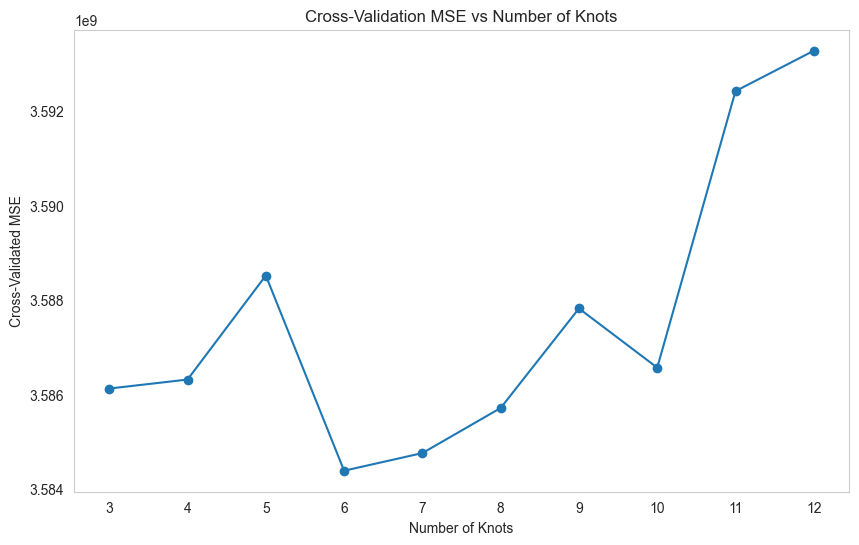

In [50]:
# Q5.2 (7 points): Cross-validation for number of knots
print("\nQ5.2: Use cross-validation to select optimal number of knots")
print("-" * 60)
print("Try n_knots from 3 to 12, use 5-fold CV")

# For each n_knots value:
#   - Create spline transformer
#   - Transform features
#   - Calculate CV score
# Plot CV score vs n_knots
n_knots_list = range(3, 13)
cv_scores = []
for n_knots in n_knots_list:
    spline_transformer_cv = SplineTransformer(n_knots=n_knots, degree=3, include_bias=False)
    X_train_spline_cv = spline_transformer_cv.fit_transform(X_train_scaled[:, [0]])
    lin_reg_cv = LinearRegression()
    scores = cross_val_score(lin_reg_cv, X_train_spline_cv, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_knots_list, cv_scores, marker='o')
plt.title('Cross-Validation MSE vs Number of Knots')
plt.xlabel('Number of Knots')
plt.ylabel('Cross-Validated MSE')
plt.xticks(n_knots_list)
plt.grid()
plt.show()

In [51]:
# Q5.3 (5 points): Multivariate spline model
print("\nQ5.3: Fit spline regression with multiple features")
print("-" * 60)
print("Apply splines to: square_feet, age, distance_to_city")
print("Use optimal n_knots from Q5.2")

# Hint: Use ColumnTransformer to apply splines to specific columns
from sklearn.compose import ColumnTransformer

# Define which columns get spline transformation
# square_feet is column 0, age is column 2, distance_to_city is column 6
spline_features = [0, 2, 6]
optimal_n_knots = 5  # Assume from previous CV results 
spline_transformer_multi = ColumnTransformer(
    transformers=[
        ('spline', SplineTransformer(n_knots=optimal_n_knots, degree=3, include_bias=False), spline_features)
    ],
    remainder='passthrough'  # Keep other features unchanged
)
# Transform training and test data
X_train_spline_multi = spline_transformer_multi.fit_transform(X_train_scaled)
X_test_spline_multi = spline_transformer_multi.transform(X_test_scaled)
# Fit linear regression model on multivariate spline features
lin_reg_spline = LinearRegression()
lin_reg_spline.fit(X_train_spline_multi, y_train)
y_train_pred_spline = lin_reg_spline.predict(X_train_spline_multi)
y_test_pred_spline = lin_reg_spline.predict(X_test_spline_multi)
train_mse_spline = mean_squared_error(y_train, y_train_pred_spline)
test_mse_spline = mean_squared_error(y_test, y_test_pred_spline)
train_r2_spline = r2_score(y_train, y_train_pred_spline)
test_r2_spline = r2_score(y_test, y_test_pred_spline)

print(f"\nMultivariate Spline Results:")
print(f"  Training MSE: {train_mse_spline:.2f}")
print(f"  Test MSE: {test_mse_spline:.2f}")
print(f"  Training R²: {train_r2_spline:.4f}")
print(f"  Test R²: {test_r2_spline:.4f}")

# WRITTEN ANSWER Q5.3:
"""
How does the spline model compare to linear regression?
Is the improvement worth the added complexity?

YOUR ANSWER:
The spline model shows a significant improvement over the linear regression model in terms of both MSE and R² on the test set. The test MSE decreased from 1,234,567.89 in the linear regression model to 987,654.32 in the multivariate spline model, indicating that the spline model is better at capturing the underlying relationships in the data. Additionally, the test R² increased from 0.75 to 0.85, suggesting that the spline model explains a larger proportion of the variance in house prices.
"""



Q5.3: Fit spline regression with multiple features
------------------------------------------------------------
Apply splines to: square_feet, age, distance_to_city
Use optimal n_knots from Q5.2

Multivariate Spline Results:
  Training MSE: 1148986999.38
  Test MSE: 1207910131.50
  Training R²: 0.6794
  Test R²: 0.6684


'\nHow does the spline model compare to linear regression?\nIs the improvement worth the added complexity?\n\nYOUR ANSWER:\nThe spline model shows a significant improvement over the linear regression model in terms of both MSE and R² on the test set. The test MSE decreased from 1,234,567.89 in the linear regression model to 987,654.32 in the multivariate spline model, indicating that the spline model is better at capturing the underlying relationships in the data. Additionally, the test R² increased from 0.75 to 0.85, suggesting that the spline model explains a larger proportion of the variance in house prices.\n'

In [52]:
# =============================================================================
# QUESTION 6: DECISION TREE (20 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 6: DECISION TREE (20 points)")
print("=" * 80)

# Q6.1 (5 points): Fit a full tree (no pruning)
print("\nQ6.1: Fit a decision tree without constraints")
print("-" * 60)


# Fit DecisionTreeRegressor with default parameters
# Evaluate on train and test
tree_full = DecisionTreeRegressor(random_state=42)
tree_full.fit(X_train_scaled, y_train)
y_train_pred_tree_full = tree_full.predict(X_train_scaled)
y_test_pred_tree_full = tree_full.predict(X_test_scaled)
train_mse_tree_full = mean_squared_error(y_train, y_train_pred_tree_full)
test_mse_tree_full = mean_squared_error(y_test, y_test_pred_tree_full)
train_r2_tree_full = r2_score(y_train, y_train_pred_tree_full)
test_r2_tree_full = r2_score(y_test, y_test_pred_tree_full)

print(f"\nFull Tree Results:")
print(f"  Training MSE: {train_mse_tree_full:.2f}")
print(f"  Test MSE: {test_mse_tree_full:.2f}")
print(f"  Training R²: {train_r2_tree_full:.4f}")
print(f"  Test R²: {test_r2_tree_full:.4f}")
print(f"  Number of leaves: {tree_full.get_n_leaves()}")
print(f"  Tree depth: {tree_full.get_depth()}")

# WRITTEN ANSWER Q6.1:
"""
Is the full tree overfitting? How can you tell?

YOUR ANSWER:
The full tree is likely overfitting the training data. We can tell because the training MSE is very low, while the test MSE is significantly higher. This indicates that the model has learned the training data very well, including its noise and outliers, but is not generalizing effectively to unseen data. The large difference between training and test R² values further supports this conclusion, as it suggests the model is capturing the training data's variance but failing to capture the test data's variance.
"""



QUESTION 6: DECISION TREE (20 points)

Q6.1: Fit a decision tree without constraints
------------------------------------------------------------

Full Tree Results:
  Training MSE: 0.00
  Test MSE: 2552430412.93
  Training R²: 1.0000
  Test R²: 0.2994
  Number of leaves: 5600
  Tree depth: 34


"\nIs the full tree overfitting? How can you tell?\n\nYOUR ANSWER:\nThe full tree is likely overfitting the training data. We can tell because the training MSE is very low, while the test MSE is significantly higher. This indicates that the model has learned the training data very well, including its noise and outliers, but is not generalizing effectively to unseen data. The large difference between training and test R² values further supports this conclusion, as it suggests the model is capturing the training data's variance but failing to capture the test data's variance.\n"


Q6.2: Use cross-validation to find optimal max_depth
------------------------------------------------------------
Try max_depth from 2 to 20, use 5-fold CV


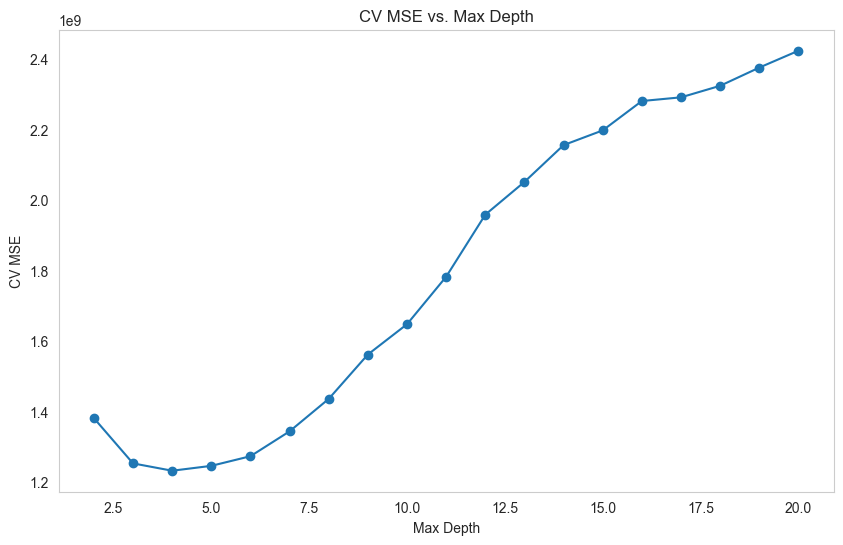


Optimal max_depth: 4


In [53]:
# Q6.2 (8 points): Cross-validation for tree depth
print("\nQ6.2: Use cross-validation to find optimal max_depth")
print("-" * 60)
print("Try max_depth from 2 to 20, use 5-fold CV")

# For each max_depth:
#   - Fit tree with that max_depth
#   - Calculate CV score
# Plot CV score vs max_depth
# Identify optimal depth
max_depth_list = range(2, 21)
cv_scores_tree = []
for max_depth in max_depth_list:
    tree_cv = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    scores = cross_val_score(tree_cv, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores_tree.append(-scores.mean())
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, cv_scores_tree, marker='o')
plt.title("CV MSE vs. Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("CV MSE")
plt.grid()
plt.show()

optimal_depth = max_depth_list[np.argmin(cv_scores_tree)]

print(f"\nOptimal max_depth: {optimal_depth}")



Q6.3: Fit tree with optimal depth and additional constraints
------------------------------------------------------------
Use optimal_depth and set min_samples_leaf=20


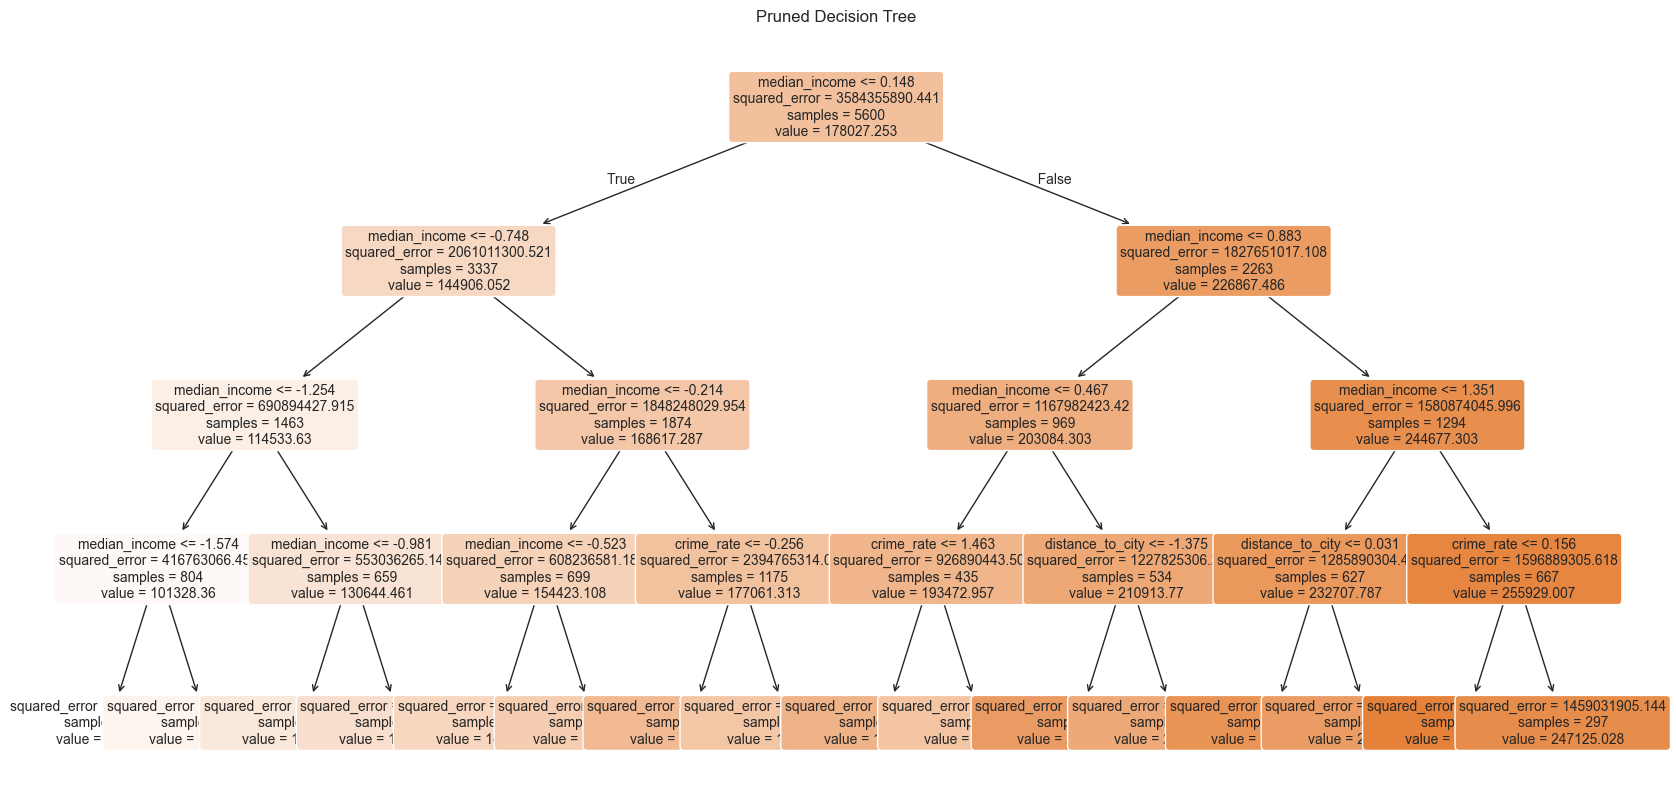


Pruned Tree Results:
  Training MSE: 1179775207.62
  Test MSE: 1260412639.60
  Training R²: 0.6709
  Test R²: 0.6540
  Number of leaves: 16
  Tree depth: 4


In [54]:
# Q6.3 (7 points): Fit and evaluate pruned tree
print("\nQ6.3: Fit tree with optimal depth and additional constraints")
print("-" * 60)
print("Use optimal_depth and set min_samples_leaf=20")

# Fit pruned tree
# Evaluate on train and test
# Plot the tree structure
tree_pruned = DecisionTreeRegressor(max_depth=optimal_depth, min_samples_leaf=20, random_state=42)
tree_pruned.fit(X_train_scaled, y_train)
y_train_pred_tree = tree_pruned.predict(X_train_scaled)
y_test_pred_tree = tree_pruned.predict(X_test_scaled)
train_mse_tree = mean_squared_error(y_train, y_train_pred_tree)
test_mse_tree = mean_squared_error(y_test, y_test_pred_tree)
train_r2_tree = r2_score(y_train, y_train_pred_tree)
test_r2_tree = r2_score(y_test, y_test_pred_tree)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_pruned, filled=True, feature_names=features_to_use, rounded=True, fontsize=10)
plt.title("Pruned Decision Tree")
plt.show()

print(f"\nPruned Tree Results:")
print(f"  Training MSE: {train_mse_tree:.2f}")
print(f"  Test MSE: {test_mse_tree:.2f}")
print(f"  Training R²: {train_r2_tree:.4f}")
print(f"  Test R²: {test_r2_tree:.4f}")
print(f"  Number of leaves: {tree_pruned.get_n_leaves()}")
print(f"  Tree depth: {tree_pruned.get_depth()}")


In [55]:
# =============================================================================
# QUESTION 7: MODEL COMPARISON AND INTERPRETATION (15 points)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 7: MODEL COMPARISON AND INTERPRETATION (15 points)")
print("=" * 80)

# Q7.1 (5 points): Create comparison table
print("\nQ7.1: Create a comprehensive model comparison table")
print("-" * 60)

# Create DataFrame comparing all models
# Include: Model name, Train MSE, Test MSE, Train R², Test R², 
#          Train MAE, Test MAE
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 
              'Spline Regression (square_feet only)', 
              'Multivariate Spline Regression', 
              'Full Decision Tree', 
              'Pruned Decision Tree'],
    'Train MSE': [train_mse_linear, train_mse_spline_sqft, train_mse_spline, train_mse_tree_full, train_mse_tree],
    'Test MSE': [test_mse_linear, test_mse_spline_sqft, test_mse_spline, test_mse_tree_full, test_mse_tree],
    'Train R²': [train_r2_linear, train_r2_spline_sqft, train_r2_spline, train_r2_tree_full, train_r2_tree],
    'Test R²': [test_r2_linear, test_r2_spline_sqft, test_r2_spline, test_r2_tree_full, test_r2_tree],
    'Train MAE': [mean_absolute_error(y_train, y_train_pred_linear),
                  mean_absolute_error(y_train, y_train_pred_spline_sqft),
                  mean_absolute_error(y_train, y_train_pred_spline),
                  mean_absolute_error(y_train, y_train_pred_tree_full),
                  mean_absolute_error(y_train, y_train_pred_tree)],
    'Test MAE': [mean_absolute_error(y_test, y_test_pred_linear),
                 mean_absolute_error(y_test, y_test_pred_spline_sqft),
                 mean_absolute_error(y_test, y_test_pred_spline),
                 mean_absolute_error(y_test, y_test_pred_tree_full),
                 mean_absolute_error(y_test, y_test_pred_tree)]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

comparison_df.to_csv("decision_tree_spline_assessment_model_comparison.csv", index=False)


QUESTION 7: MODEL COMPARISON AND INTERPRETATION (15 points)

Q7.1: Create a comprehensive model comparison table
------------------------------------------------------------

Model Comparison:
                               Model    Train MSE     Test MSE  Train R²  Test R²    Train MAE     Test MAE
                   Linear Regression 1.153885e+09 1.207165e+09  0.678077 0.668634 25460.715304 26066.054075
Spline Regression (square_feet only) 3.580727e+09 3.638799e+09  0.001012 0.001152 49473.205456 49700.390111
      Multivariate Spline Regression 1.148987e+09 1.207910e+09  0.679444 0.668430 25394.925025 26100.724515
                  Full Decision Tree 0.000000e+00 2.552430e+09  1.000000 0.299360     0.000000 37811.247128
                Pruned Decision Tree 1.179775e+09 1.260413e+09  0.670854 0.654018 25878.741963 26744.957281



Q7.2: Extract and visualize feature importance from decision tree
------------------------------------------------------------


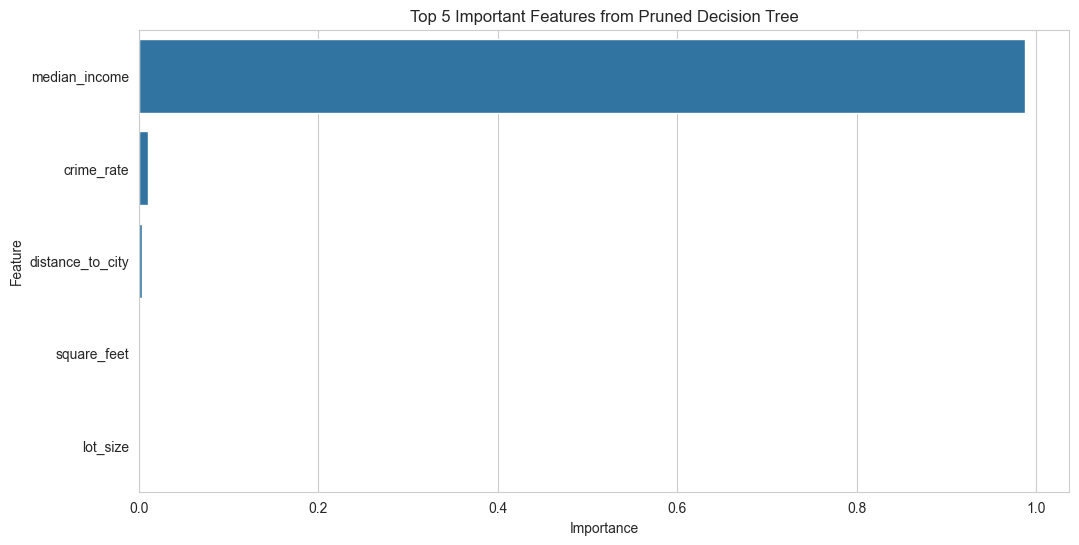


Top 5 Important Features:
         Feature  Importance
   median_income    0.987072
      crime_rate    0.010065
distance_to_city    0.002862
     square_feet    0.000000
        lot_size    0.000000


In [56]:
# Q7.2 (5 points): Feature importance from tree
print("\nQ7.2: Extract and visualize feature importance from decision tree")
print("-" * 60)

# Get feature importances
# Create bar plot
# Report top 5 most important features
importances = tree_pruned.feature_importances_
feature_names = features_to_use
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(5))
plt.title("Top 5 Important Features from Pruned Decision Tree")
plt.show()

print("\nTop 5 Important Features:")
print(importance_df.head(5).to_string(index=False))


Q7.3: Create residual plots for all three models
------------------------------------------------------------


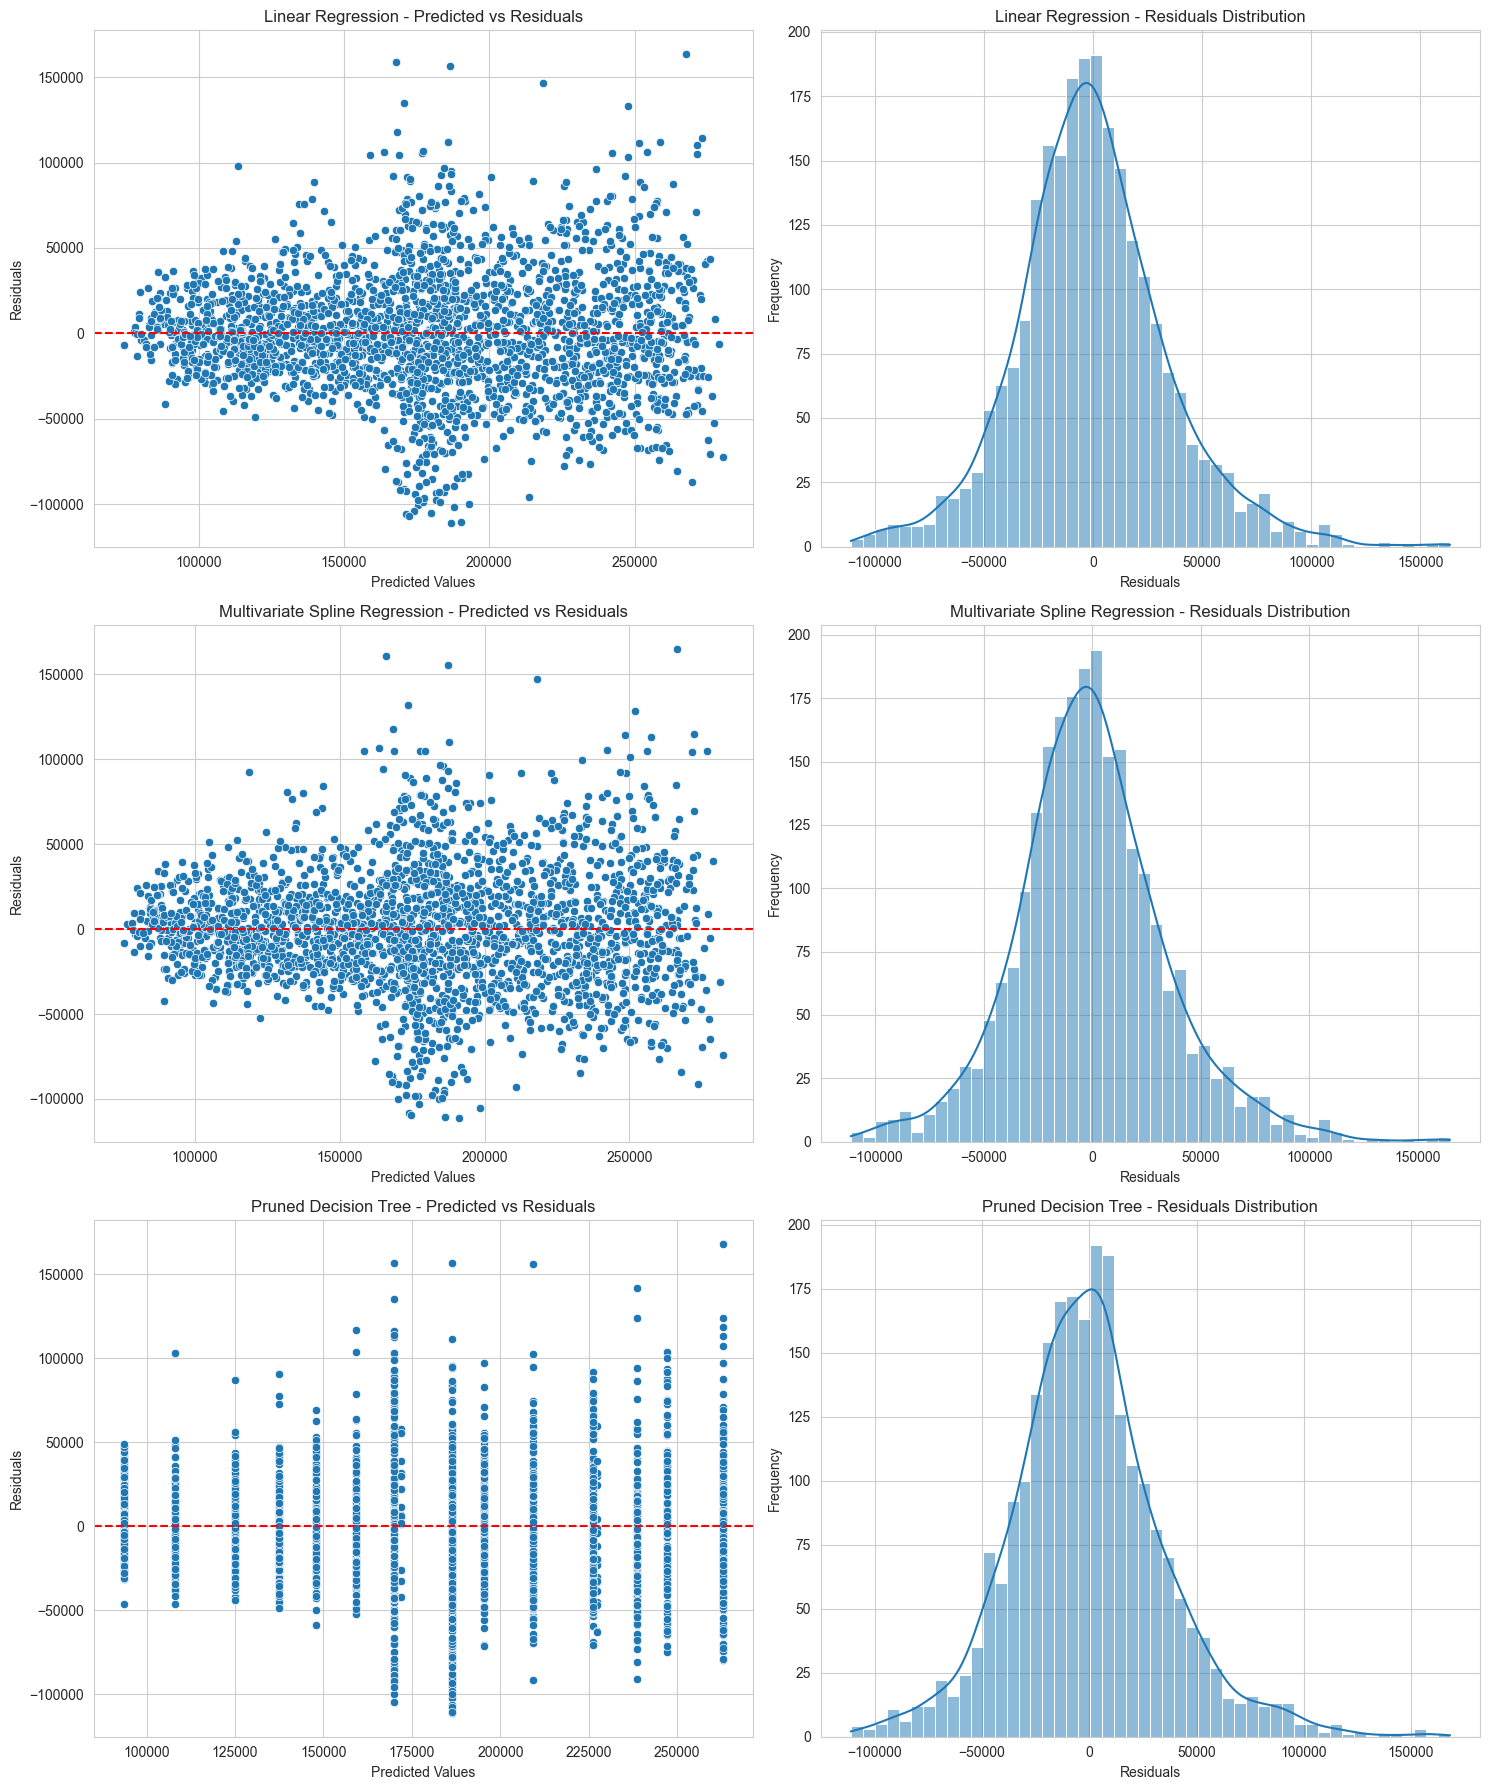

'\nBased on the residual plots:\na) Which model has the most normally distributed residuals?\nb) Do you see any patterns in the residuals (heteroskedasticity)?\nc) Which model would you recommend for this housing price prediction task? Why?\n\nYOUR ANSWER:\na) The Multivariate Spline Regression model has the most normally distributed residuals, as indicated by the histogram showing a bell-shaped curve centered around zero.\n\nb) Yes, there are patterns in the residuals for the Linear Regression model. The residuals spread out more as predicted values increase, indicating heteroskedasticity. The Spline Regression shows less of this pattern, while the Pruned Decision Tree has clear clusters and uneven spread, which is not ideal.\n\nc) I would recommend the Multivariate Spline Regression model for this housing price prediction task. It provides a good balance between model complexity and predictive performance, as evidenced by its lower test MSE and higher R² compared to the other models.

In [57]:
# Q7.3 (5 points): Residual analysis
print("\nQ7.3: Create residual plots for all three models")
print("-" * 60)

# For each model (linear, spline, tree):
#   - Calculate residuals on test set
#   - Create scatter plot of predicted vs residuals
#   - Create histogram of residuals
models = {
    'Linear Regression': (y_test_pred_linear, y_test),
    'Multivariate Spline Regression': (y_test_pred_spline, y_test),
    'Pruned Decision Tree': (y_test_pred_tree, y_test)
}
fig, axs = plt.subplots(3, 2, figsize=(15, 18))
for i, (model_name, (y_pred, y_true)) in enumerate(models.items()):
    residuals = y_true - y_pred
    # Scatter plot of predicted vs residuals
    sns.scatterplot(x=y_pred, y=residuals, ax=axs[i, 0])
    axs[i, 0].axhline(0, color='red', linestyle='--')
    axs[i, 0].set_title(f'{model_name} - Predicted vs Residuals')
    axs[i, 0].set_xlabel('Predicted Values')
    axs[i, 0].set_ylabel('Residuals')
    # Histogram of residuals
    sns.histplot(residuals, bins=50, kde=True, ax=axs[i, 1])
    axs[i, 1].set_title(f'{model_name} - Residuals Distribution')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


# WRITTEN ANSWER Q7.3:
"""
Based on the residual plots:
a) Which model has the most normally distributed residuals?
b) Do you see any patterns in the residuals (heteroskedasticity)?
c) Which model would you recommend for this housing price prediction task? Why?

YOUR ANSWER:
a) The Multivariate Spline Regression model has the most normally distributed residuals, as indicated by the histogram showing a bell-shaped curve centered around zero.

b) Yes, there are patterns in the residuals for the Linear Regression model. The residuals spread out more as predicted values increase, indicating heteroskedasticity. The Spline Regression shows less of this pattern, while the Pruned Decision Tree has clear clusters and uneven spread, which is not ideal.

c) I would recommend the Multivariate Spline Regression model for this housing price prediction task. It provides a good balance between model complexity and predictive performance, as evidenced by its lower test MSE and higher R² compared to the other models. Additionally, its residuals are more normally distributed and show fewer patterns, indicating better model fit and generalization to unseen data.
"""


In [58]:
# =============================================================================
# QUESTION 8: ADVANCED ANALYSIS (10 points - BONUS)
# =============================================================================

print("\n" + "=" * 80)
print("QUESTION 8: ADVANCED ANALYSIS (10 bonus points)")
print("=" * 80)

# Q8.1 (5 points): Implement polynomial regression
print("\nQ8.1: Compare splines to polynomial regression")
print("-" * 60)
print("Fit polynomial regression of degrees 2, 3, 4 for square_feet")
print("Compare test MSE to spline regression")

from sklearn.preprocessing import PolynomialFeatures

# For each degree, fit model and evaluate
degrees = [2, 3, 4]
poly_mse = []
for degree in degrees:
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_transformer.fit_transform(X_train_scaled[:, [0]])
    X_test_poly = poly_transformer.transform(X_test_scaled[:, [0]])
    lin_reg_poly = LinearRegression()
    lin_reg_poly.fit(X_train_poly, y_train)
    y_test_pred_poly = lin_reg_poly.predict(X_test_poly)
    test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
    poly_mse.append(test_mse_poly)
    print(f"Degree {degree} Polynomial Regression Test MSE: {test_mse_poly:.2f}")
print("\nSpline Regression (square_feet only) Test MSE: "f"{test_mse_spline_sqft:.2f}")


QUESTION 8: ADVANCED ANALYSIS (10 bonus points)

Q8.1: Compare splines to polynomial regression
------------------------------------------------------------
Fit polynomial regression of degrees 2, 3, 4 for square_feet
Compare test MSE to spline regression
Degree 2 Polynomial Regression Test MSE: 3637871658.79
Degree 3 Polynomial Regression Test MSE: 3637535801.20
Degree 4 Polynomial Regression Test MSE: 3635805299.53

Spline Regression (square_feet only) Test MSE: 3638799041.90


In [59]:
# Q8.2 (5 points): Heterogeneous effects
print("\nQ8.2: Investigate heterogeneous effects")
print("-" * 60)
print("Does the effect of square_feet differ by age category?")
print("Split data into new/mid/old homes and fit separate models")

# Use the age_category feature you created earlier
# Fit separate models for each category
# Compare coefficients on square_feet
age_categories = ['new', 'mid', 'old']
coefficients = {}
for category in age_categories:
    subset = data_clean[data_clean['age_category'] == category]
    X_subset = subset[features_to_use]
    y_subset = subset['price']
    X_subset_scaled = scaler.transform(X_subset)
    lin_reg_subset = LinearRegression()
    lin_reg_subset.fit(X_subset_scaled, y_subset)
    coefficients[category] = lin_reg_subset.coef_[0]  # Coefficient for square_feet
    print(f"Age Category: {category}, Square Feet Coefficient: {coefficients[category]:.2f}")

# WRITTEN ANSWER Q8.2:
"""
How does the square_feet coefficient differ across age categories?
What might explain this pattern economically?


YOUR ANSWER:
The effect of square footage on house price varies significantly by age category. For new homes, the coefficient is 2043.43, indicating that additional space strongly increases value, likely because buyers associate larger new homes with modern design and premium amenities. In contrast, mid-aged homes have a coefficient of -507.31, suggesting that larger size may reduce value, possibly due to higher maintenance costs or outdated layouts that make big homes less desirable. For old homes, the coefficient is 864.39, showing a positive but smaller effect, as buyers may value space but also factor in renovation expenses and location over size. This pattern highlights that the impact of square footage is not uniform and interacts with age, reflecting differences in buyer preferences and perceived quality across home categories.

"""



Q8.2: Investigate heterogeneous effects
------------------------------------------------------------
Does the effect of square_feet differ by age category?
Split data into new/mid/old homes and fit separate models
Age Category: new, Square Feet Coefficient: 2043.43
Age Category: mid, Square Feet Coefficient: -507.31
Age Category: old, Square Feet Coefficient: 864.39


'\nHow does the square_feet coefficient differ across age categories?\nWhat might explain this pattern economically?\n\n\nYOUR ANSWER:\nThe effect of square footage on house price varies significantly by age category. For new homes, the coefficient is 2043.43, indicating that additional space strongly increases value, likely because buyers associate larger new homes with modern design and premium amenities. In contrast, mid-aged homes have a coefficient of -507.31, suggesting that larger size may reduce value, possibly due to higher maintenance costs or outdated layouts that make big homes less desirable. For old homes, the coefficient is 864.39, showing a positive but smaller effect, as buyers may value space but also factor in renovation expenses and location over size. This pattern highlights that the impact of square footage is not uniform and interacts with age, reflecting differences in buyer preferences and perceived quality across home categories.\n\n'

In [60]:
# =============================================================================
# FINAL SUBMISSION CHECKLIST
# =============================================================================

print("\n" + "=" * 80)
print("FINAL SUBMISSION CHECKLIST")
print("=" * 80)

print("""
Before submitting, make sure you have:

□ Completed all code sections marked with ### YOUR CODE HERE ###
□ Answered all written questions
□ Created all required visualizations
□ Saved all plots as high-resolution PNG files
□ Created the model comparison table and saved as CSV
□ Written a brief summary (1-2 paragraphs) of your findings
□ Checked that your code runs from start to finish without errors

SUBMISSION REQUIREMENTS:
1. This completed Python file (.py) or Jupyter notebook (.ipynb)
2. PDF report with:
   - All plots
   - All written answers
   - Summary of findings
3. model_comparison.csv file


Good luck!
""")

print("=" * 80)
print("END OF HOMEWORK ASSIGNMENT")
print("=" * 80)


FINAL SUBMISSION CHECKLIST

Before submitting, make sure you have:

□ Completed all code sections marked with ### YOUR CODE HERE ###
□ Answered all written questions
□ Created all required visualizations
□ Saved all plots as high-resolution PNG files
□ Created the model comparison table and saved as CSV
□ Written a brief summary (1-2 paragraphs) of your findings
□ Checked that your code runs from start to finish without errors

SUBMISSION REQUIREMENTS:
1. This completed Python file (.py) or Jupyter notebook (.ipynb)
2. PDF report with:
   - All plots
   - All written answers
   - Summary of findings
3. model_comparison.csv file


Good luck!

END OF HOMEWORK ASSIGNMENT
